DRAFT TA

Hendrawan Aulia Rahman

# IMPORT LIBRARY AND DATASET

In [3]:
import pandas as pd
import re
import nltk
import zipfile
import os
import string
import json
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from google.colab import drive
from tensorflow.keras.models import load_model
#download transformers
!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys
from helper_functions import plot_loss_curves
from helper_functions import calculate_results


--2024-06-20 06:21:50--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-06-20 06:21:51 (34.6 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
zip_file_path = "/content/drive/My Drive/tugas_akhir_hendrawan/LK-Hadith-Corpus-master.zip"

In [6]:


with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall("LK-Hadith-Corpus-master")


df = pd.DataFrame(columns=['Chapter_Number', 'Chapter_English', 'Chapter_Arabic',
                           'Section_Number', 'Section_English', 'Section_Arabic',
                           'Hadith_number', 'English_Hadith', 'English_Isnad',
                           'English_Matn', 'Arabic_Hadith', 'Arabic_Isnad',
                           'Arabic_Matn', 'Arabic_Comment', 'English_Grade',
                           'Arabic_Grade'])

for root, dirs, files in os.walk("LK-Hadith-Corpus-master"):
    for file in files:
        if file.endswith(".csv"):
            csv_file_path = os.path.join(root, file)
            df_list = [df, pd.read_csv(csv_file_path)]
            df = pd.concat(df_list, ignore_index=True)



#UNDERSTANDING THE DATA

In [7]:
df.head(5)

,Chapter_Number,Chapter_English,Chapter_Arabic,Section_Number,Section_English,Section_Arabic,Hadith_number,English_Hadith,English_Isnad,English_Matn,Arabic_Hadith,Arabic_Isnad,Arabic_Matn,Arabic_Comment,English_Grade,Arabic_Grade
0,20,The Book on Vows and Oaths,كتاب النذور والأيمان عن رسول الله صلى الله علي...,1,What Has Been Related From The Messenger Of A...,باب مَا جَاءَ عَنْ رَسُولِ اللَّهِ صلى الله عل...,1557,Narrated 'Aishah: That the Messenger of Allah ...,Narrated 'Aishah:,"That the Messenger of Allah (ﷺ) said: ""There i...",حَدَّثَنَا قُتَيْبَةُ، حَدَّثَنَا أَبُو صَفْوَ...,حَدَّثَنَا قُتَيْبَةُ، حَدَّثَنَا أَبُو صَفْوَ...,قَالَ رَسُولُ اللَّهِ صلى الله عليه وسلم لاَ ن...,‏ ‏.‏ قَالَ وَفِي الْبَابِ عَنِ ابْنِ عُمَرَ و...,Sahih - Authentic,صحيح
1,20,The Book on Vows and Oaths,كتاب النذور والأيمان عن رسول الله صلى الله علي...,1,What Has Been Related From The Messenger Of A...,باب مَا جَاءَ عَنْ رَسُولِ اللَّهِ صلى الله عل...,1558,"Narrated 'Aishah: That the Prophet (ﷺ) said: ""...",Narrated 'Aishah:,"That the Prophet (ﷺ) said: ""There is no vowing...",حَدَّثَنَا أَبُو إِسْمَاعِيلَ التِّرْمِذِيُّ، ...,حَدَّثَنَا أَبُو إِسْمَاعِيلَ التِّرْمِذِيُّ، ...,عَنِ النَّبِيِّ صلى الله عليه وسلم قَالَ لاَ ن...,‏ ‏.‏ قَالَ أَبُو عِيسَى هَذَا حَدِيثٌ غَرِيبٌ...,Sahih - Authentic,صحيح
2,20,The Book on Vows and Oaths,كتاب النذور والأيمان عن رسول الله صلى الله علي...,2,"Whoever Vows To Obey Allah, Then He Should Ob...",باب مَنْ نَذَرَ أَنْ يُطِيعَ اللَّهَ فَلْيُطِع...,1559,"Narrated 'Aishah: That the Prophet (ﷺ) said: ""...",Narrated 'Aishah:,"That the Prophet (ﷺ) said: ""Whoever vowed to o...",حَدَّثَنَا قُتَيْبَةُ بْنُ سَعِيدٍ، عَنْ مَالِ...,حَدَّثَنَا قُتَيْبَةُ بْنُ سَعِيدٍ، عَنْ مَالِ...,عَنِ النَّبِيِّ صلى الله عليه وسلم قَالَ مَنْ ...,‏ ‏.‏,Sahih - Authentic,صحيح
3,20,The Book on Vows and Oaths,كتاب النذور والأيمان عن رسول الله صلى الله علي...,2,"Whoever Vows To Obey Allah, Then He Should Ob...",باب مَنْ نَذَرَ أَنْ يُطِيعَ اللَّهَ فَلْيُطِع...,1560,Narrated Thabit bin Adh-Dahhak: Another Chain ...,Narrated Thabit bin Adh-Dahhak:,Another Chain with similar meanings.,حَدَّثَنَا الْحَسَنُ بْنُ عَلِيٍّ الْخَلاَّلُ،...,حَدَّثَنَا الْحَسَنُ بْنُ عَلِيٍّ الْخَلاَّلُ،...,عَنِ النَّبِيِّ صلى الله عليه وسلم نَحْوَهُ قَ...,NaN,NaN,NaN
4,20,The Book on Vows and Oaths,كتاب النذور والأيمان عن رسول الله صلى الله علي...,3,What Has Been Related About There Is No Vowin...,باب مَا جَاءَ لاَ نَذْرَ فِيمَا لاَ يَمْلِكُ ا...,1561,Narrated Thabit bin Adh-Dahhak: That the Proph...,Narrated Thabit bin Adh-Dahhak:,"That the Prophet (ﷺ) said: ""It is not for a pe...",حَدَّثَنَا أَحْمَدُ بْنُ مَنِيعٍ، حَدَّثَنَا إ...,حَدَّثَنَا أَحْمَدُ بْنُ مَنِيعٍ، حَدَّثَنَا إ...,عَنِ النَّبِيِّ صلى الله عليه وسلم قَالَ لَيْس...,‏ ‏.‏ قَالَ وَفِي الْبَابِ عَنْ عَبْدِ اللَّهِ...,Sahih - Authentic,صحيح


In [8]:
df[['English_Hadith','English_Matn','English_Isnad','English_Grade']]

,English_Hadith,English_Matn,English_Isnad,English_Grade
0,Narrated 'Aishah: That the Messenger of Allah ...,"That the Messenger of Allah (ﷺ) said: ""There i...",Narrated 'Aishah:,Sahih - Authentic
1,"Narrated 'Aishah: That the Prophet (ﷺ) said: ""...","That the Prophet (ﷺ) said: ""There is no vowing...",Narrated 'Aishah:,Sahih - Authentic
2,"Narrated 'Aishah: That the Prophet (ﷺ) said: ""...","That the Prophet (ﷺ) said: ""Whoever vowed to o...",Narrated 'Aishah:,Sahih - Authentic
3,Narrated Thabit bin Adh-Dahhak: Another Chain ...,Another Chain with similar meanings.,Narrated Thabit bin Adh-Dahhak:,NaN
4,Narrated Thabit bin Adh-Dahhak: That the Proph...,"That the Prophet (ﷺ) said: ""It is not for a pe...",Narrated Thabit bin Adh-Dahhak:,Sahih - Authentic
...,...,...,...,...
34083,Narrated Ibn Mas'ud: Alqamah and al-Aswad said...,Alqamah and al-Aswad said: A man came to Ibn M...,Narrated Ibn Mas'ud:,NaN
34084,'Abd al-Rahman b. Yazid said: I asked Abu Mas'...,I asked Abu Mas'ud while he was making circuma...,'Abd al-Rahman b. Yazid said:,Sahih - Authentic
34085,Narrated Abdullah ibn Amr ibn al-'As: The Prop...,The Prophet (ﷺ) said: If anyone prays at night...,Narrated Abdullah ibn Amr ibn al-'As:,Sahih - Authentic
34086,Narrated Abdullah ibn Amr: A man came to the M...,A man came to the Messenger of Allah (ﷺ) and s...,Narrated Abdullah ibn Amr:,Daif - Weak


In [9]:
df['English_Hadith'][0]

'Narrated \'Aishah: That the Messenger of Allah (ﷺ) said: "There is no vowing for disobedience, and its atonement is the atonement of an oath."'

In [10]:
df['English_Grade'].value_counts()

English_Grade
Sahih - Authentic                                                                19695
Sahih-Authentic                                                                   7345
Daif - Weak                                                                       2958
Hasan - Good                                                                      2655
                                                                                   412
Hasan Sahih                                                                        217
Da'if in chain                                                                     100
Sahih in chain                                                                      67
Sahih Maqtu'                                                                        52
Sahih li ghairih                                                                    36
Hasan in chain                                                                      30
Maudu - Fabricated           

# PRE-PROCESSING

In [11]:
df['English_Grade'] = df['English_Grade'].replace('Sahih-Authentic', 'Sahih - Authentic')

In [12]:
df = df[df['English_Grade'].isin(['Sahih - Authentic', 'Daif - Weak', 'Hasan - Good'])]

In [13]:
df = df[['English_Matn', 'English_Grade', 'English_Isnad']]

In [14]:
df.head(5)

,English_Matn,English_Grade,English_Isnad
0,"That the Messenger of Allah (ﷺ) said: ""There i...",Sahih - Authentic,Narrated 'Aishah:
1,"That the Prophet (ﷺ) said: ""There is no vowing...",Sahih - Authentic,Narrated 'Aishah:
2,"That the Prophet (ﷺ) said: ""Whoever vowed to o...",Sahih - Authentic,Narrated 'Aishah:
4,"That the Prophet (ﷺ) said: ""It is not for a pe...",Sahih - Authentic,Narrated Thabit bin Adh-Dahhak:
5,"That the Messenger of Allah (ﷺ) said: ""The ato...",Daif - Weak,Narrated 'Uqbah bin 'Amir:


## PUNCTUATION REMOVAL

In [15]:
def remove_punctuation(text):
    punctuation_list = string.punctuation + 'ﷺ'
    translator = str.maketrans('', '', punctuation_list)
    text_no_punctuation = text.translate(translator)
    return text_no_punctuation

In [16]:
df = df.applymap(lambda x: remove_punctuation(x) if isinstance(x, str) else '')

In [17]:
df['English_Matn'].head(5)

0    That the Messenger of Allah  said There is no ...
1    That the Prophet  said There is no vowing in d...
2    That the Prophet  said Whoever vowed to obey A...
4    That the Prophet  said It is not for a person ...
5    That the Messenger of Allah  said The atonemen...
Name: English_Matn, dtype: object

## STOP WORDS REMOVAL

In [18]:
nltk.download('stopwords')

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    text_without_stopwords = ' '.join(filtered_words)
    return text_without_stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [19]:
df = df.applymap(remove_stopwords)

In [20]:
df['English_Matn'].head(5)

0    Messenger Allah said vowing disobedience atone...
1    Prophet said vowing disobedience Allah atoneme...
2    Prophet said Whoever vowed obey Allah obey who...
4                      Prophet said person vow control
5    Messenger Allah said atonement vow specified a...
Name: English_Matn, dtype: object

##STEMMING

In [21]:
nltk.download('punkt')
def stemming(text):
    stemmer = PorterStemmer()
    words = nltk.word_tokenize(text)
    stemmed_words = [stemmer.stem(word.lower()) for word in words]
    stemmed_text = ' '.join(stemmed_words)
    return stemmed_text

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [22]:
df = df.applymap(stemming)

In [23]:
df['English_Matn'].head(5)

0       messeng allah said vow disobedi aton aton oath
1       prophet said vow disobedi allah aton aton oath
2    prophet said whoever vow obey allah obey whoev...
4                      prophet said person vow control
5        messeng allah said aton vow specifi aton oath
Name: English_Matn, dtype: object

## ONE HOT ENCODING

In [24]:
one_hot_encoded = pd.get_dummies(df['English_Grade'])
df= pd.concat([df, one_hot_encoded], axis=1)

In [25]:
df.head(5)

,English_Matn,English_Grade,English_Isnad,daif weak,hasan good,sahih authent
0,messeng allah said vow disobedi aton aton oath,sahih authent,narrat aishah,False,False,True
1,prophet said vow disobedi allah aton aton oath,sahih authent,narrat aishah,False,False,True
2,prophet said whoever vow obey allah obey whoev...,sahih authent,narrat aishah,False,False,True
4,prophet said person vow control,sahih authent,narrat thabit bin adhdahhak,False,False,True
5,messeng allah said aton vow specifi aton oath,daif weak,narrat uqbah bin amir,True,False,False


In [26]:
grade_mapping = {
    "sahih authent": 0,
    "hasan good": 1,
    "daif weak": 2
}

In [27]:
df["English_Grade"] = df["English_Grade"].map(grade_mapping)

In [28]:
df.head(5)

,English_Matn,English_Grade,English_Isnad,daif weak,hasan good,sahih authent
0,messeng allah said vow disobedi aton aton oath,0,narrat aishah,False,False,True
1,prophet said vow disobedi allah aton aton oath,0,narrat aishah,False,False,True
2,prophet said whoever vow obey allah obey whoev...,0,narrat aishah,False,False,True
4,prophet said person vow control,0,narrat thabit bin adhdahhak,False,False,True
5,messeng allah said aton vow specifi aton oath,2,narrat uqbah bin amir,True,False,False


## OVER SAMPLING

In [29]:
from sklearn.utils import resample
df_grade1 = df[df['English_Grade'] == 0]
df_grade2_3 = df[df['English_Grade'].isin([1, 2])]
df_grade2_3_oversampled = resample(df_grade2_3,
                                    replace=True,
                                    n_samples=2 * len(df_grade1),
                                    random_state=42)
df = pd.concat([df_grade1, df_grade2_3_oversampled])

In [30]:
df.head(5)

,English_Matn,English_Grade,English_Isnad,daif weak,hasan good,sahih authent
0,messeng allah said vow disobedi aton aton oath,0,narrat aishah,False,False,True
1,prophet said vow disobedi allah aton aton oath,0,narrat aishah,False,False,True
2,prophet said whoever vow obey allah obey whoev...,0,narrat aishah,False,False,True
4,prophet said person vow control,0,narrat thabit bin adhdahhak,False,False,True
6,messeng allah said abdurrahman ask posit leade...,0,narrat abdurrahman bin samurah,False,False,True


## SPLIT DATA

In [31]:
x = df['English_Isnad']
x2 = df['English_Matn']
y = df[['sahih authent', 'hasan good', 'daif weak']]

In [32]:
x_train_03, x_test_03, y_train_03, y_test_03 = train_test_split(x.to_numpy(), y.to_numpy(), test_size=0.3, random_state=42)
x_train2_03, x_test2_03, y_train2_03, y_test2_03 = train_test_split(x2.to_numpy(), y.to_numpy(), test_size=0.3, random_state=42)

# FEATURE EXTRACTION

In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
x_train_03 = model.encode(x_train_03)
x_test_03 = model.encode(x_test_03)
x_train2_03 = model.encode(x_train2_03)
x_test2_03 = model.encode(x_test2_03)

x_train_tensor_03 = tf.convert_to_tensor(x_train_03)
x_test_tensor_03 = tf.convert_to_tensor(x_test_03)
x_train_tensor2_03 = tf.convert_to_tensor(x_train2_03)
x_test_tensor2_03 = tf.convert_to_tensor(x_test2_03)

y_train_tensor_03 = tf.convert_to_tensor(y_train_03)
y_test_tensor_03 = tf.convert_to_tensor(y_test_03)
y_train_tensor2_03 = tf.convert_to_tensor(y_train2_03)
y_test_tensor2_03 = tf.convert_to_tensor(y_test2_03)


In [ ]:
x_train_03

array([[ 0.00798484,  0.13681886, -0.05909518, ...,  0.00201381,
        -0.02566177,  0.00249226],
       [-0.04992728,  0.10490952, -0.02382735, ...,  0.001169  ,
        -0.05861025, -0.00059023],
       [ 0.04144542,  0.13010573,  0.01738767, ...,  0.0280763 ,
         0.0222108 , -0.01040981],
       ...,
       [ 0.0162007 ,  0.06627271,  0.01238892, ...,  0.05119153,
        -0.00742113, -0.01356431],
       [-0.015844  ,  0.14379026, -0.04323388, ...,  0.01333706,
         0.04794744, -0.01241566],
       [-0.02971983,  0.05834503, -0.04281287, ...,  0.02229658,
        -0.02532708,  0.04261325]], dtype=float32)

In [ ]:
np.save('/content/drive/MyDrive/tugas_akhir_hendrawan/x_train_tensor_03.npy', x_train_tensor_03)
np.save('/content/drive/MyDrive/tugas_akhir_hendrawan/x_test_tensor_03.npy', x_test_tensor_03)
np.save('/content/drive/MyDrive/tugas_akhir_hendrawan/x_train_tensor2_03.npy', x_train_tensor2_03)
np.save('/content/drive/MyDrive/tugas_akhir_hendrawan/x_test_tensor2_03.npy', x_test_tensor2_03)

np.save('/content/drive/MyDrive/tugas_akhir_hendrawan/y_train_tensor_03.npy', y_train_tensor_03)
np.save('/content/drive/MyDrive/tugas_akhir_hendrawan/y_test_tensor_03.npy', y_test_tensor_03)
np.save('/content/drive/MyDrive/tugas_akhir_hendrawan/y_train_tensor2_03.npy', y_train_tensor2_03)
np.save('/content/drive/MyDrive/tugas_akhir_hendrawan/y_test_tensor2_03.npy', y_test_tensor2_03)

In [38]:
x_train_tensor_03 = np.load('/content/drive/MyDrive/tugas_akhir_hendrawan/x_train_tensor_03.npy')
x_test_tensor_03 = np.load('/content/drive/MyDrive/tugas_akhir_hendrawan/x_test_tensor_03.npy')
x_train_tensor2_03 = np.load('/content/drive/MyDrive/tugas_akhir_hendrawan/x_train_tensor2_03.npy')
x_test_tensor2_03 = np.load('/content/drive/MyDrive/tugas_akhir_hendrawan/x_test_tensor2_03.npy')

y_train_tensor_03 = np.load('/content/drive/MyDrive/tugas_akhir_hendrawan/y_train_tensor_03.npy')
y_test_tensor_03 = np.load('/content/drive/MyDrive/tugas_akhir_hendrawan/y_test_tensor_03.npy')
y_train_tensor2_03 = np.load('/content/drive/MyDrive/tugas_akhir_hendrawan/y_train_tensor2_03.npy')
y_test_tensor2_03 = np.load('/content/drive/MyDrive/tugas_akhir_hendrawan/y_test_tensor2_03.npy')

x_train_tensor_03 = tf.convert_to_tensor(x_train_tensor_03)
x_test_tensor_03 = tf.convert_to_tensor(x_test_tensor_03)
x_train_tensor2_03 = tf.convert_to_tensor(x_train_tensor2_03)
x_test_tensor2_03 = tf.convert_to_tensor(x_test_tensor2_03)

y_train_tensor_03 = tf.convert_to_tensor(y_train_tensor_03)
y_test_tensor_03 = tf.convert_to_tensor(y_test_tensor_03)
y_train_tensor2_03 = tf.convert_to_tensor(y_train_tensor2_03)
y_test_tensor2_03 = tf.convert_to_tensor(y_test_tensor2_03)

# SKENARIO 1

## LSTM ISNAD

In [ ]:
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((1, 384), input_shape=(384,)),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(3, activation='softmax')
])
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_1_history = model_1.fit(x_train_tensor_03,
                              y_train_tensor_03,
                              epochs=50,
                              validation_data=(x_test_tensor_03, y_test_tensor_03),
                              )

model_1.save("/content/drive/My Drive/tugas_akhir_hendrawan/model_1.h5")
history_dict = model_1_history.history
json_path = '/content/drive/MyDrive/tugas_akhir_hendrawan/model_1_history.json'
with open(json_path, 'w') as f:
    json.dump(history_dict, f)

Epoch 1/50
1775/1775 [==============================] - 13s 5ms/step - loss: 0.9674 - accuracy: 0.5115 - val_loss: 0.9401 - val_accuracy: 0.5325
Epoch 2/50
1775/1775 [==============================] - 10s 6ms/step - loss: 0.9241 - accuracy: 0.5420 - val_loss: 0.9167 - val_accuracy: 0.5422
Epoch 3/50
1775/1775 [==============================] - 10s 6ms/step - loss: 0.9009 - accuracy: 0.5601 - val_loss: 0.8983 - val_accuracy: 0.5637
Epoch 4/50
1775/1775 [==============================] - 9s 5ms/step - loss: 0.8808 - accuracy: 0.5770 - val_loss: 0.8814 - val_accuracy: 0.5735
Epoch 5/50
1775/1775 [==============================] - 10s 6ms/step - loss: 0.8627 - accuracy: 0.5894 - val_loss: 0.8683 - val_accuracy: 0.5786
Epoch 6/50
1775/1775 [==============================] - 10s 6ms/step - loss: 0.8457 - accuracy: 0.6006 - val_loss: 0.8682 - val_accuracy: 0.5727
Epoch 7/50
1775/1775 [==============================] - 10s 6ms/step - loss: 0.8294 - accuracy: 0.6103 - val_loss: 0.8385 - val_acc

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [39]:
with open('/content/drive/MyDrive/tugas_akhir_hendrawan/model_1_history.json', 'r') as f:
    loaded_history_json_1 = json.load(f)
# print("History dari JSON:", loaded_history_json_1)

model_1 = load_model('/content/drive/My Drive/tugas_akhir_hendrawan/model_1.h5')

In [40]:
def evaluate_classification(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return accuracy, precision, recall, f1

prediksi1 = model_1.predict(x_test_tensor_03)
prediksi1 = np.argmax(prediksi1, axis=1)
jawaban1 = np.argmax(y_test_tensor_03, axis=1)

accuracy, precision, recall, f1 = evaluate_classification(jawaban1, prediksi1)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

761/761 [==============================] - 2s 2ms/step
Accuracy: 0.7288790269559501
Precision: 0.7304560564548241
Recall: 0.7288790269559501
F1 Score: 0.7283494578411459


In [41]:
performa_model_1 = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1-score': f1
}

json_path = '/content/drive/MyDrive/tugas_akhir_hendrawan/performa_model_1.json'
with open(json_path, 'w') as f:
    json.dump(performa_model_1, f)

In [42]:
with open('/content/drive/MyDrive/tugas_akhir_hendrawan/performa_model_1.json', 'r') as f:
    loaded_performa_model_1 = json.load(f)

In [43]:
loaded_performa_model_1

{'accuracy': 0.7288790269559501,
 'precision': 0.7304560564548241,
 'recall': 0.7288790269559501,
 'f1-score': 0.7283494578411459}

## LSTM MATAN

In [ ]:
model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((1, 384), input_shape=(384,)),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(3, activation='softmax')
])
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_2_history = model_2.fit(x_train_tensor2_03,
                              y_train_tensor2_03,
                              epochs=50,
                              validation_data=(x_test_tensor2_03, y_test_tensor2_03),
                              )
model_2.save("/content/drive/My Drive/tugas_akhir_hendrawan/model_2.h5")
history_dict = model_2_history.history
json_path = '/content/drive/MyDrive/tugas_akhir_hendrawan/model_2_history.json'
with open(json_path, 'w') as f:
    json.dump(history_dict, f)

Epoch 1/50
1775/1775 [==============================] - 12s 6ms/step - loss: 1.0249 - accuracy: 0.4704 - val_loss: 0.9973 - val_accuracy: 0.4899
Epoch 2/50
1775/1775 [==============================] - 10s 5ms/step - loss: 0.9819 - accuracy: 0.5116 - val_loss: 0.9791 - val_accuracy: 0.5039
Epoch 3/50
1775/1775 [==============================] - 10s 5ms/step - loss: 0.9478 - accuracy: 0.5403 - val_loss: 0.9449 - val_accuracy: 0.5482
Epoch 4/50
1775/1775 [==============================] - 11s 6ms/step - loss: 0.8931 - accuracy: 0.5830 - val_loss: 0.8784 - val_accuracy: 0.5949
Epoch 5/50
1775/1775 [==============================] - 11s 6ms/step - loss: 0.8255 - accuracy: 0.6323 - val_loss: 0.8181 - val_accuracy: 0.6407
Epoch 6/50
1775/1775 [==============================] - 10s 5ms/step - loss: 0.7554 - accuracy: 0.6798 - val_loss: 0.7585 - val_accuracy: 0.6790
Epoch 7/50
1775/1775 [==============================] - 9s 5ms/step - loss: 0.6900 - accuracy: 0.7206 - val_loss: 0.6994 - val_acc

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [44]:
with open('/content/drive/MyDrive/tugas_akhir_hendrawan/model_2_history.json', 'r') as f:
    loaded_history_json_2 = json.load(f)
# print("History dari JSON:", loaded_history_json)
model_2 = load_model('/content/drive/My Drive/tugas_akhir_hendrawan/model_2.h5')

In [45]:
prediksi2 = model_2.predict(x_test_tensor2_03)
prediksi2 = np.argmax(prediksi2, axis=1)
jawaban2 = np.argmax(y_test_tensor2_03, axis=1)

accuracy, precision, recall, f1 = evaluate_classification(jawaban2, prediksi2)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

761/761 [==============================] - 2s 2ms/step
Accuracy: 0.9770299145299145
Precision: 0.9776104396147436
Recall: 0.9770299145299145
F1 Score: 0.9769858540147828


In [46]:
performa_model_2 = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1-score': f1
}

json_path = '/content/drive/MyDrive/tugas_akhir_hendrawan/performa_model_2.json'
with open(json_path, 'w') as f:
    json.dump(performa_model_2, f)
with open('/content/drive/MyDrive/tugas_akhir_hendrawan/performa_model_2.json', 'r') as f:
    loaded_performa_model_2 = json.load(f)
loaded_performa_model_2

{'accuracy': 0.9770299145299145,
 'precision': 0.9776104396147436,
 'recall': 0.9770299145299145,
 'f1-score': 0.9769858540147828}

<ipython-input-47-62d58603f21b>:4: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(range(len(loaded_history_json_1['accuracy'])), loaded_history_json_1['accuracy'], 'r-', label='Model Isnad',linestyle='-')
<ipython-input-47-62d58603f21b>:5: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "g-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(range(len(loaded_history_json_2['accuracy'])), loaded_history_json_2['accuracy'], 'g-', label='Model Matan',linestyle='--')


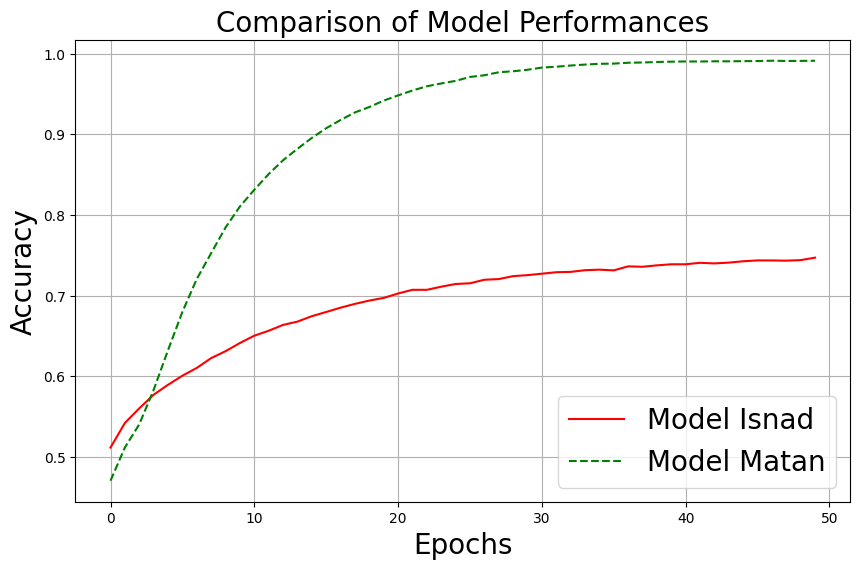

In [47]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
# epochs = range(len(loaded_history_json_2['accuracy']))
plt.plot(range(len(loaded_history_json_1['accuracy'])), loaded_history_json_1['accuracy'], 'r-', label='Model Isnad',linestyle='-')
plt.plot(range(len(loaded_history_json_2['accuracy'])), loaded_history_json_2['accuracy'], 'g-', label='Model Matan',linestyle='--')
plt.title('Comparison of Model Performances', fontsize=20)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.legend(fontsize=20)
plt.grid(True)
plt.show()

# SKENARIO 2

## RNN MATN

In [ ]:
model_3 = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((1, 384), input_shape=(384,)),
    tf.keras.layers.SimpleRNN(64),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


# Fit model
model_3_history = model_3.fit(x_train_tensor2_03,
                              y_train_tensor2_03,
                              epochs=50,
                              validation_data=(x_test_tensor2_03, y_test_tensor2_03),
                              )
model_3.save("/content/drive/My Drive/tugas_akhir_hendrawan/model_3.h5")
history_dict = model_3_history.history
json_path = '/content/drive/MyDrive/tugas_akhir_hendrawan/model_3_history.json'
with open(json_path, 'w') as f:
    json.dump(history_dict, f)

Epoch 1/50
1775/1775 [==============================] - 12s 6ms/step - loss: 1.0244 - accuracy: 0.4699 - val_loss: 1.0095 - val_accuracy: 0.4886
Epoch 2/50
1775/1775 [==============================] - 10s 6ms/step - loss: 0.9989 - accuracy: 0.4988 - val_loss: 1.0011 - val_accuracy: 0.4967
Epoch 3/50
1775/1775 [==============================] - 9s 5ms/step - loss: 0.9922 - accuracy: 0.5044 - val_loss: 0.9942 - val_accuracy: 0.4994
Epoch 4/50
1775/1775 [==============================] - 11s 6ms/step - loss: 0.9881 - accuracy: 0.5088 - val_loss: 0.9935 - val_accuracy: 0.5014
Epoch 5/50
1775/1775 [==============================] - 10s 6ms/step - loss: 0.9866 - accuracy: 0.5116 - val_loss: 0.9940 - val_accuracy: 0.4934
Epoch 6/50
1775/1775 [==============================] - 10s 5ms/step - loss: 0.9850 - accuracy: 0.5112 - val_loss: 0.9948 - val_accuracy: 0.5010
Epoch 7/50
1775/1775 [==============================] - 9s 5ms/step - loss: 0.9836 - accuracy: 0.5133 - val_loss: 0.9911 - val_accu

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [48]:
with open('/content/drive/MyDrive/tugas_akhir_hendrawan/model_3_history.json', 'r') as f:
    loaded_history_json_3 = json.load(f)
# print("History dari JSON:", loaded_history_json)
model_3 = load_model('/content/drive/My Drive/tugas_akhir_hendrawan/model_3.h5')

In [49]:
prediksi3 = model_3.predict(x_test_tensor2_03)
prediksi3 = np.argmax(prediksi3, axis=1)
jawaban3 = np.argmax(y_test_tensor2_03, axis=1)

accuracy, precision, recall, f1 = evaluate_classification(jawaban3, prediksi3)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


761/761 [==============================] - 1s 2ms/step
Accuracy: 0.6111522024983563
Precision: 0.6120793912311489
Recall: 0.6111522024983563
F1 Score: 0.6110155046610107


In [50]:
performa_model_3 = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1-score': f1
}

json_path = '/content/drive/MyDrive/tugas_akhir_hendrawan/performa_model_3.json'
with open(json_path, 'w') as f:
    json.dump(performa_model_3, f)
with open('/content/drive/MyDrive/tugas_akhir_hendrawan/performa_model_3.json', 'r') as f:
    loaded_performa_model_3 = json.load(f)
loaded_performa_model_3

{'accuracy': 0.6111522024983563,
 'precision': 0.6120793912311489,
 'recall': 0.6111522024983563,
 'f1-score': 0.6110155046610107}

## CNN MATN

In [ ]:
model_4 = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((384, 1), input_shape=(384,)),
    tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3, activation='softmax')
])
model_4.compile(loss="categorical_crossentropy",
                   optimizer=tf.keras.optimizers.Adam(),
                   metrics=["accuracy"])
model_4_history = model_4.fit(x_train_tensor2_03,
                                   y_train_tensor2_03,
                                   epochs=50,
                                   validation_data=(x_test_tensor2_03, y_test_tensor2_03),
                                   )
model_4.save("/content/drive/My Drive/tugas_akhir_hendrawan/model_4.h5")
history_dict = model_4_history.history
json_path = '/content/drive/MyDrive/tugas_akhir_hendrawan/model_4_history.json'
with open(json_path, 'w') as f:
    json.dump(history_dict, f)

Epoch 1/50
1775/1775 [==============================] - 10s 5ms/step - loss: 1.0180 - accuracy: 0.4783 - val_loss: 0.9727 - val_accuracy: 0.5346
Epoch 2/50
1775/1775 [==============================] - 8s 5ms/step - loss: 0.9451 - accuracy: 0.5479 - val_loss: 0.9387 - val_accuracy: 0.5558
Epoch 3/50
1775/1775 [==============================] - 9s 5ms/step - loss: 0.9059 - accuracy: 0.5822 - val_loss: 0.9131 - val_accuracy: 0.5723
Epoch 4/50
1775/1775 [==============================] - 9s 5ms/step - loss: 0.8776 - accuracy: 0.6025 - val_loss: 0.9558 - val_accuracy: 0.5405
Epoch 5/50
1775/1775 [==============================] - 7s 4ms/step - loss: 0.8523 - accuracy: 0.6208 - val_loss: 0.8692 - val_accuracy: 0.6137
Epoch 6/50
1775/1775 [==============================] - 9s 5ms/step - loss: 0.8301 - accuracy: 0.6361 - val_loss: 0.8618 - val_accuracy: 0.5992
Epoch 7/50
1775/1775 [==============================] - 8s 5ms/step - loss: 0.8096 - accuracy: 0.6479 - val_loss: 0.8288 - val_accuracy

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [51]:
with open('/content/drive/MyDrive/tugas_akhir_hendrawan/model_4_history.json', 'r') as f:
    loaded_history_json_4 = json.load(f)
# print("History dari JSON:", loaded_history_json)
model_4 = load_model('/content/drive/My Drive/tugas_akhir_hendrawan/model_4.h5')

In [52]:
prediksi4 = model_4.predict(x_test_tensor2_03)
prediksi4 = np.argmax(prediksi4, axis=1)
jawaban4 = np.argmax(y_test_tensor2_03, axis=1)

accuracy, precision, recall, f1 = evaluate_classification(jawaban4, prediksi4)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


761/761 [==============================] - 2s 2ms/step
Accuracy: 0.7879684418145957
Precision: 0.8088533172309663
Recall: 0.7879684418145957
F1 Score: 0.7865131215929672


In [53]:
performa_model_4 = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1-score': f1
}

json_path = '/content/drive/MyDrive/tugas_akhir_hendrawan/performa_model_4.json'
with open(json_path, 'w') as f:
    json.dump(performa_model_4, f)
with open('/content/drive/MyDrive/tugas_akhir_hendrawan/performa_model_4.json', 'r') as f:
    loaded_performa_model_4 = json.load(f)
loaded_performa_model_4

{'accuracy': 0.7879684418145957,
 'precision': 0.8088533172309663,
 'recall': 0.7879684418145957,
 'f1-score': 0.7865131215929672}

<ipython-input-55-17c3d43676c7>:4: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(epochs, loaded_history_json_2['accuracy'], 'r-', label='Model LSTM', linestyle='-')
<ipython-input-55-17c3d43676c7>:5: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "g-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(epochs, loaded_history_json_3['accuracy'], 'g-', label='Model RNN',linestyle='--')
<ipython-input-55-17c3d43676c7>:6: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(epochs, loaded_history_json_4['accuracy'], 'b-', label='Model CNN',linestyle=':')


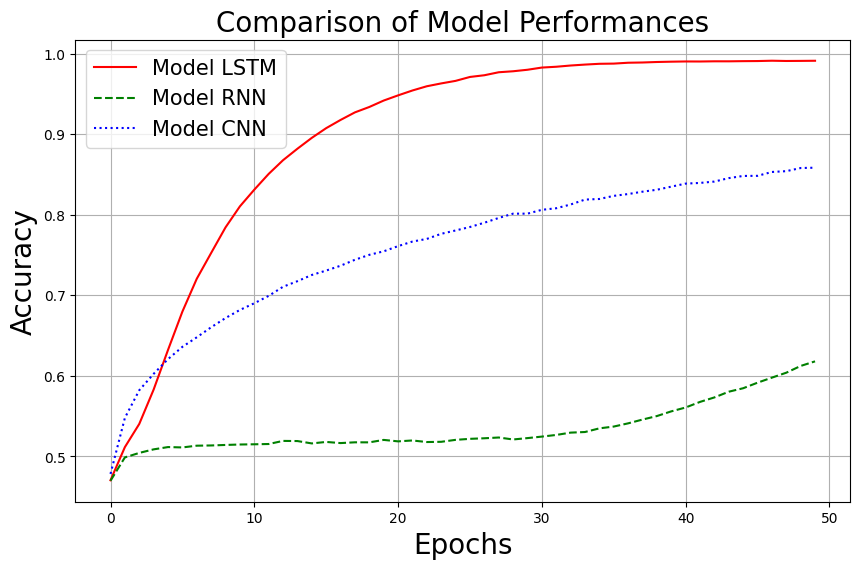

In [55]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
epochs = range(len(loaded_history_json_2['accuracy']))
plt.plot(epochs, loaded_history_json_2['accuracy'], 'r-', label='Model LSTM', linestyle='-')
plt.plot(epochs, loaded_history_json_3['accuracy'], 'g-', label='Model RNN',linestyle='--')
plt.plot(epochs, loaded_history_json_4['accuracy'], 'b-', label='Model CNN',linestyle=':')
plt.title('Comparison of Model Performances', fontsize=20)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.legend(fontsize=15)
plt.grid(True)
plt.show()

# SKENARIO 3

## Test size 0.3

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop5 = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_5 = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((1, 384), input_shape=(384,)),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(3, activation='softmax')
])
model_5.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_5_history = model_5.fit(x_train_tensor2_03,
                              y_train_tensor2_03,
                              epochs=70,
                              validation_data=(x_test_tensor2_03, y_test_tensor2_03),
                              callbacks=[early_stop5],
                              )
model_5.save("/content/drive/My Drive/tugas_akhir_hendrawan/model_5.h5")
history_dict = model_5_history.history
json_path = '/content/drive/MyDrive/tugas_akhir_hendrawan/model_5_history.json'
with open(json_path, 'w') as f:
    json.dump(history_dict, f)

Epoch 1/70
1775/1775 [==============================] - 12s 6ms/step - loss: 1.0240 - accuracy: 0.4697 - val_loss: 1.0018 - val_accuracy: 0.4873
Epoch 2/70
1775/1775 [==============================] - 9s 5ms/step - loss: 0.9807 - accuracy: 0.5114 - val_loss: 0.9739 - val_accuracy: 0.5203
Epoch 3/70
1775/1775 [==============================] - 11s 6ms/step - loss: 0.9459 - accuracy: 0.5409 - val_loss: 0.9380 - val_accuracy: 0.5471
Epoch 4/70
1775/1775 [==============================] - 10s 6ms/step - loss: 0.8927 - accuracy: 0.5846 - val_loss: 0.8839 - val_accuracy: 0.6007
Epoch 5/70
1775/1775 [==============================] - 9s 5ms/step - loss: 0.8258 - accuracy: 0.6347 - val_loss: 0.8196 - val_accuracy: 0.6409
Epoch 6/70
1775/1775 [==============================] - 11s 6ms/step - loss: 0.7567 - accuracy: 0.6796 - val_loss: 0.7604 - val_accuracy: 0.6794
Epoch 7/70
1775/1775 [==============================] - 10s 5ms/step - loss: 0.6879 - accuracy: 0.7203 - val_loss: 0.7130 - val_accu

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [56]:
with open('/content/drive/MyDrive/tugas_akhir_hendrawan/model_5_history.json', 'r') as f:
    loaded_history_json_5 = json.load(f)
# print("History dari JSON:", loaded_history_json)
model_5 = load_model('/content/drive/My Drive/tugas_akhir_hendrawan/model_5.h5')

In [57]:
prediksi5 = model_5.predict(x_test_tensor2_03)
prediksi5 = np.argmax(prediksi5, axis=1)
jawaban5 = np.argmax(y_test_tensor2_03, axis=1)

accuracy, precision, recall, f1 = evaluate_classification(jawaban5, prediksi5)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


761/761 [==============================] - 2s 2ms/step
Accuracy: 0.977646285338593
Precision: 0.9781154044941822
Recall: 0.977646285338593
F1 Score: 0.977610544756903


In [58]:
performa_model_5 = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1-score': f1
}

json_path = '/content/drive/MyDrive/tugas_akhir_hendrawan/performa_model_5.json'
with open(json_path, 'w') as f:
    json.dump(performa_model_5, f)
with open('/content/drive/MyDrive/tugas_akhir_hendrawan/performa_model_5.json', 'r') as f:
    loaded_performa_model_5 = json.load(f)
loaded_performa_model_5

{'accuracy': 0.977646285338593,
 'precision': 0.9781154044941822,
 'recall': 0.977646285338593,
 'f1-score': 0.977610544756903}

## Test size 0.2

In [ ]:
x_train2_02, x_test2_02, y_train2_02, y_test2_02 = train_test_split(x2.to_numpy(), y.to_numpy(), test_size=0.2, random_state=42)

In [ ]:
x_train2_02 = model.encode(x_train2_02)
x_test2_02 = model.encode(x_test2_02)

x_train_tensor2_02 = tf.convert_to_tensor(x_train2_02)
x_test_tensor2_02 = tf.convert_to_tensor(x_test2_02)

y_train_tensor2_02 = tf.convert_to_tensor(y_train2_02)
y_test_tensor2_02 = tf.convert_to_tensor(y_test2_02)


In [ ]:
np.save('/content/drive/MyDrive/tugas_akhir_hendrawan/x_train_tensor2_02.npy', x_train_tensor2_02)
np.save('/content/drive/MyDrive/tugas_akhir_hendrawan/x_test_tensor2_02.npy', x_test_tensor2_02)

np.save('/content/drive/MyDrive/tugas_akhir_hendrawan/y_train_tensor2_02.npy', y_train_tensor2_02)
np.save('/content/drive/MyDrive/tugas_akhir_hendrawan/y_test_tensor2_02.npy', y_test_tensor2_02)

In [59]:
x_train_tensor2_02 = np.load('/content/drive/MyDrive/tugas_akhir_hendrawan/x_train_tensor2_02.npy')
x_test_tensor2_02 = np.load('/content/drive/MyDrive/tugas_akhir_hendrawan/x_test_tensor2_02.npy')


y_train_tensor2_02 = np.load('/content/drive/MyDrive/tugas_akhir_hendrawan/y_train_tensor2_02.npy')
y_test_tensor2_02 = np.load('/content/drive/MyDrive/tugas_akhir_hendrawan/y_test_tensor2_02.npy')


x_train_tensor2_02 = tf.convert_to_tensor(x_train_tensor2_02)
x_test_tensor2_02 = tf.convert_to_tensor(x_test_tensor2_02)

y_train_tensor2_02 = tf.convert_to_tensor(y_train_tensor2_02)
y_test_tensor2_02 = tf.convert_to_tensor(y_test_tensor2_02)

In [ ]:
early_stop6 = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_6 = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((1, 384), input_shape=(384,)),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(3, activation='softmax')
])
model_6.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_6_history = model_6.fit(x_train_tensor2_02,
                              y_train_tensor2_02,
                              epochs=70,
                              validation_data=(x_test_tensor2_02, y_test_tensor2_02),
                              callbacks=[early_stop6],
                              )
model_6.save("/content/drive/My Drive/tugas_akhir_hendrawan/model_6.h5")
history_dict = model_6_history.history
json_path = '/content/drive/MyDrive/tugas_akhir_hendrawan/model_6_history.json'
with open(json_path, 'w') as f:
    json.dump(history_dict, f)

Epoch 1/70
2028/2028 [==============================] - 12s 5ms/step - loss: 1.0207 - accuracy: 0.4746 - val_loss: 1.0070 - val_accuracy: 0.4971
Epoch 2/70
2028/2028 [==============================] - 9s 4ms/step - loss: 0.9765 - accuracy: 0.5146 - val_loss: 0.9643 - val_accuracy: 0.5333
Epoch 3/70
2028/2028 [==============================] - 10s 5ms/step - loss: 0.9313 - accuracy: 0.5530 - val_loss: 0.9182 - val_accuracy: 0.5632
Epoch 4/70
2028/2028 [==============================] - 10s 5ms/step - loss: 0.8646 - accuracy: 0.6051 - val_loss: 0.8482 - val_accuracy: 0.6242
Epoch 5/70
2028/2028 [==============================] - 9s 4ms/step - loss: 0.7869 - accuracy: 0.6602 - val_loss: 0.7818 - val_accuracy: 0.6654
Epoch 6/70
2028/2028 [==============================] - 10s 5ms/step - loss: 0.7122 - accuracy: 0.7058 - val_loss: 0.7151 - val_accuracy: 0.7037
Epoch 7/70
2028/2028 [==============================] - 9s 5ms/step - loss: 0.6412 - accuracy: 0.7446 - val_loss: 0.6595 - val_accur

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [60]:
with open('/content/drive/MyDrive/tugas_akhir_hendrawan/model_6_history.json', 'r') as f:
    loaded_history_json_6 = json.load(f)
# print("History dari JSON:", loaded_history_json)
model_6 = load_model('/content/drive/My Drive/tugas_akhir_hendrawan/model_6.h5')

In [61]:
prediksi6 = model_6.predict(x_test_tensor2_02)
prediksi6 = np.argmax(prediksi6, axis=1)
jawaban6 = np.argmax(y_test_tensor2_02, axis=1)

accuracy, precision, recall, f1 = evaluate_classification(jawaban6, prediksi6)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


507/507 [==============================] - 1s 2ms/step
Accuracy: 0.9567924063116371
Precision: 0.9582872727621193
Recall: 0.9567924063116371
F1 Score: 0.9564134172368922


In [62]:
performa_model_6 = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1-score': f1
}

json_path = '/content/drive/MyDrive/tugas_akhir_hendrawan/performa_model_6.json'
with open(json_path, 'w') as f:
    json.dump(performa_model_6, f)
with open('/content/drive/MyDrive/tugas_akhir_hendrawan/performa_model_6.json', 'r') as f:
    loaded_performa_model_6 = json.load(f)
loaded_performa_model_6

{'accuracy': 0.9567924063116371,
 'precision': 0.9582872727621193,
 'recall': 0.9567924063116371,
 'f1-score': 0.9564134172368922}

## Test size 0.1

In [ ]:
x_train2_01, x_test2_01, y_train2_01, y_test2_01 = train_test_split(x2.to_numpy(), y.to_numpy(), test_size=0.1, random_state=42)

In [ ]:
x_train2_01 = model.encode(x_train2_01)
x_test2_01 = model.encode(x_test2_01)

x_train_tensor2_01 = tf.convert_to_tensor(x_train2_01)
x_test_tensor2_01 = tf.convert_to_tensor(x_test2_01)

y_train_tensor2_01 = tf.convert_to_tensor(y_train2_01)
y_test_tensor2_01 = tf.convert_to_tensor(y_test2_01)


In [ ]:
np.save('/content/drive/MyDrive/tugas_akhir_hendrawan/x_train_tensor2_01.npy', x_train_tensor2_01)
np.save('/content/drive/MyDrive/tugas_akhir_hendrawan/x_test_tensor2_01.npy', x_test_tensor2_01)

np.save('/content/drive/MyDrive/tugas_akhir_hendrawan/y_train_tensor2_01.npy', y_train_tensor2_01)
np.save('/content/drive/MyDrive/tugas_akhir_hendrawan/y_test_tensor2_01.npy', y_test_tensor2_01)

In [63]:
x_train_tensor2_01 = np.load('/content/drive/MyDrive/tugas_akhir_hendrawan/x_train_tensor2_01.npy')
x_test_tensor2_01 = np.load('/content/drive/MyDrive/tugas_akhir_hendrawan/x_test_tensor2_01.npy')


y_train_tensor2_01 = np.load('/content/drive/MyDrive/tugas_akhir_hendrawan/y_train_tensor2_01.npy')
y_test_tensor2_01 = np.load('/content/drive/MyDrive/tugas_akhir_hendrawan/y_test_tensor2_01.npy')


x_train_tensor2_01 = tf.convert_to_tensor(x_train_tensor2_01)
x_test_tensor2_01 = tf.convert_to_tensor(x_test_tensor2_01)

y_train_tensor2_01 = tf.convert_to_tensor(y_train_tensor2_01)
y_test_tensor2_01 = tf.convert_to_tensor(y_test_tensor2_01)

In [ ]:
early_stop7 = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_7 = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((1, 384), input_shape=(384,)),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(3, activation='softmax')
])
model_7.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_7_history = model_7.fit(x_train_tensor2_01,
                              y_train_tensor2_01,
                              epochs=70,
                              validation_data=(x_test_tensor2_01, y_test_tensor2_01),
                              callbacks=[early_stop7],
                              )
model_7.save("/content/drive/My Drive/tugas_akhir_hendrawan/model_7.h5")
history_dict = model_7_history.history
json_path = '/content/drive/MyDrive/tugas_akhir_hendrawan/model_7_history.json'
with open(json_path, 'w') as f:
    json.dump(history_dict, f)

Epoch 1/70
2282/2282 [==============================] - 13s 5ms/step - loss: 1.0175 - accuracy: 0.4748 - val_loss: 0.9959 - val_accuracy: 0.4904
Epoch 2/70
2282/2282 [==============================] - 11s 5ms/step - loss: 0.9711 - accuracy: 0.5177 - val_loss: 0.9574 - val_accuracy: 0.5263
Epoch 3/70
2282/2282 [==============================] - 11s 5ms/step - loss: 0.9149 - accuracy: 0.5643 - val_loss: 0.9013 - val_accuracy: 0.5799
Epoch 4/70
2282/2282 [==============================] - 10s 4ms/step - loss: 0.8362 - accuracy: 0.6241 - val_loss: 0.8242 - val_accuracy: 0.6354
Epoch 5/70
2282/2282 [==============================] - 11s 5ms/step - loss: 0.7508 - accuracy: 0.6820 - val_loss: 0.7445 - val_accuracy: 0.6797
Epoch 6/70
2282/2282 [==============================] - 11s 5ms/step - loss: 0.6686 - accuracy: 0.7303 - val_loss: 0.6834 - val_accuracy: 0.7194
Epoch 7/70
2282/2282 [==============================] - 11s 5ms/step - loss: 0.5946 - accuracy: 0.7695 - val_loss: 0.6114 - val_ac

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [64]:
with open('/content/drive/MyDrive/tugas_akhir_hendrawan/model_7_history.json', 'r') as f:
    loaded_history_json_7 = json.load(f)
# print("History dari JSON:", loaded_history_json)
model_7 = load_model('/content/drive/My Drive/tugas_akhir_hendrawan/model_7.h5')

In [65]:
prediksi7 = model_7.predict(x_test_tensor2_01)
prediksi7 = np.argmax(prediksi7, axis=1)
jawaban7 = np.argmax(y_test_tensor2_01, axis=1)

accuracy, precision, recall, f1 = evaluate_classification(jawaban7, prediksi7)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


254/254 [==============================] - 1s 2ms/step
Accuracy: 0.951060157790927
Precision: 0.9534058381458823
Recall: 0.951060157790927
F1 Score: 0.9504780284933709


In [66]:
performa_model_7 = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1-score': f1
}

json_path = '/content/drive/MyDrive/tugas_akhir_hendrawan/performa_model_7.json'
with open(json_path, 'w') as f:
    json.dump(performa_model_7, f)
with open('/content/drive/MyDrive/tugas_akhir_hendrawan/performa_model_7.json', 'r') as f:
    loaded_performa_model_7 = json.load(f)
loaded_performa_model_7

{'accuracy': 0.951060157790927,
 'precision': 0.9534058381458823,
 'recall': 0.951060157790927,
 'f1-score': 0.9504780284933709}

<ipython-input-68-719bc8b3b96e>:4: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(range(len(loaded_history_json_5['accuracy'])), loaded_history_json_5['accuracy'], 'r-', label='Model Rasio Test Size 0.3', linestyle='-')
<ipython-input-68-719bc8b3b96e>:5: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "g-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(range(len(loaded_history_json_6['accuracy'])), loaded_history_json_6['accuracy'], 'g-', label='Model Rasio Test Size 0.2', linestyle='--')
<ipython-input-68-719bc8b3b96e>:6: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(range(len(loaded_history_json_7['accuracy'])), loaded_history_json_7['accuracy

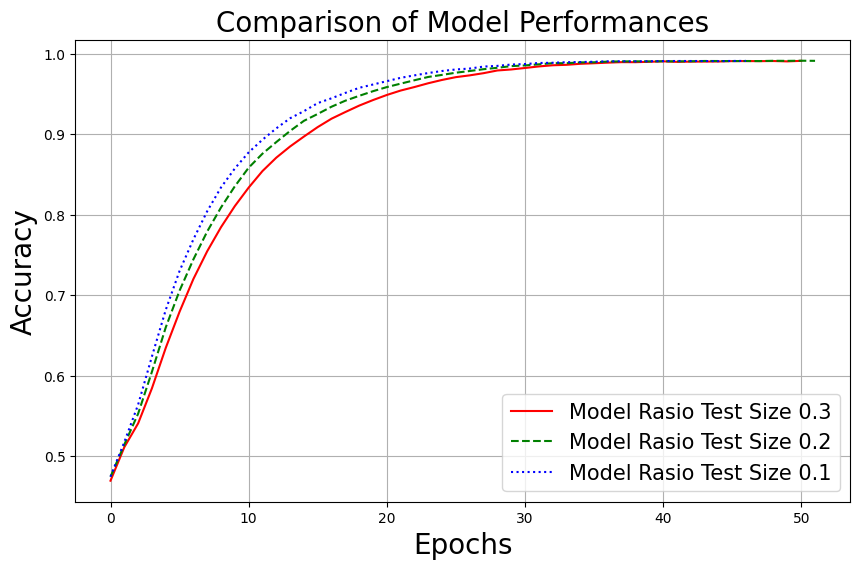

In [68]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
# epochs = range(len(loaded_history_json_2['accuracy']))
plt.plot(range(len(loaded_history_json_5['accuracy'])), loaded_history_json_5['accuracy'], 'r-', label='Model Rasio Test Size 0.3', linestyle='-')
plt.plot(range(len(loaded_history_json_6['accuracy'])), loaded_history_json_6['accuracy'], 'g-', label='Model Rasio Test Size 0.2', linestyle='--')
plt.plot(range(len(loaded_history_json_7['accuracy'])), loaded_history_json_7['accuracy'], 'b-', label='Model Rasio Test Size 0.1', linestyle=':')
plt.title('Comparison of Model Performances', fontsize=20)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.legend(fontsize=15)
plt.grid(True)
plt.show()

# SKENARIO 4

## Learning Rate 0.1

In [ ]:
early_stop8 = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_8 = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((1, 384), input_shape=(384,)),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(3, activation='softmax')
])
model_8.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
                metrics=["accuracy"])
model_8_history = model_8.fit(x_train_tensor2_01,
                              y_train_tensor2_01,
                              epochs=70,
                              validation_data=(x_test_tensor2_01, y_test_tensor2_01),
                              callbacks=[early_stop8],
                              )
model_8.save("/content/drive/My Drive/tugas_akhir_hendrawan/model_8.h5")
history_dict = model_8_history.history
json_path = '/content/drive/MyDrive/tugas_akhir_hendrawan/model_8_history.json'
with open(json_path, 'w') as f:
    json.dump(history_dict, f)

Epoch 1/70
2282/2282 [==============================] - 13s 5ms/step - loss: 1.0178 - accuracy: 0.4565 - val_loss: 0.9734 - val_accuracy: 0.4707
Epoch 2/70
2282/2282 [==============================] - 11s 5ms/step - loss: 0.9409 - accuracy: 0.5166 - val_loss: 0.9259 - val_accuracy: 0.5390
Epoch 3/70
2282/2282 [==============================] - 10s 4ms/step - loss: 0.8926 - accuracy: 0.5562 - val_loss: 0.8893 - val_accuracy: 0.5673
Epoch 4/70
2282/2282 [==============================] - 11s 5ms/step - loss: 0.8554 - accuracy: 0.5885 - val_loss: 0.8614 - val_accuracy: 0.5905
Epoch 5/70
2282/2282 [==============================] - 11s 5ms/step - loss: 0.8202 - accuracy: 0.6172 - val_loss: 0.8408 - val_accuracy: 0.6119
Epoch 6/70
2282/2282 [==============================] - 11s 5ms/step - loss: 0.7923 - accuracy: 0.6366 - val_loss: 0.8135 - val_accuracy: 0.6405
Epoch 7/70
2282/2282 [==============================] - 10s 4ms/step - loss: 0.7713 - accuracy: 0.6516 - val_loss: 0.7915 - val_ac

KeyboardInterrupt: 

In [69]:
with open('/content/drive/MyDrive/tugas_akhir_hendrawan/model_8_history.json', 'r') as f:
    loaded_history_json_8 = json.load(f)
# print("History dari JSON:", loaded_history_json)
model_8 = load_model('/content/drive/My Drive/tugas_akhir_hendrawan/model_8.h5')

In [70]:
prediksi8 = model_8.predict(x_test_tensor2_01)
prediksi8 = np.argmax(prediksi8, axis=1)
jawaban8 = np.argmax(y_test_tensor2_01, axis=1)

accuracy, precision, recall, f1 = evaluate_classification(jawaban8, prediksi8)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


254/254 [==============================] - 1s 3ms/step
Accuracy: 0.8187869822485208
Precision: 0.8349861857881675
Recall: 0.8187869822485208
F1 Score: 0.819226414055177


In [71]:
performa_model_8 = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1-score': f1
}

json_path = '/content/drive/MyDrive/tugas_akhir_hendrawan/performa_model_8.json'
with open(json_path, 'w') as f:
    json.dump(performa_model_8, f)
with open('/content/drive/MyDrive/tugas_akhir_hendrawan/performa_model_8.json', 'r') as f:
    loaded_performa_model_8 = json.load(f)
loaded_performa_model_8

{'accuracy': 0.8187869822485208,
 'precision': 0.8349861857881675,
 'recall': 0.8187869822485208,
 'f1-score': 0.819226414055177}

## Learning rate 0.01

In [ ]:
early_stop9 = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_9 = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((1, 384), input_shape=(384,)),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(3, activation='softmax')
])
model_9.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                metrics=["accuracy"])
model_9_history = model_9.fit(x_train_tensor2_01,
                              y_train_tensor2_01,
                              epochs=70,
                              validation_data=(x_test_tensor2_01, y_test_tensor2_01),
                              callbacks=[early_stop9],
                              )
model_9.save("/content/drive/My Drive/tugas_akhir_hendrawan/model_9.h5")
history_dict = model_9_history.history
json_path = '/content/drive/MyDrive/tugas_akhir_hendrawan/model_9_history.json'
with open(json_path, 'w') as f:
    json.dump(history_dict, f)

In [72]:
with open('/content/drive/MyDrive/tugas_akhir_hendrawan/model_9_history.json', 'r') as f:
    loaded_history_json_9 = json.load(f)
# print("History dari JSON:", loaded_history_json)
model_9 = load_model('/content/drive/My Drive/tugas_akhir_hendrawan/model_9.h5')

In [73]:
prediksi9 = model_9.predict(x_test_tensor2_01)
prediksi9 = np.argmax(prediksi9, axis=1)
jawaban9 = np.argmax(y_test_tensor2_01, axis=1)

accuracy, precision, recall, f1 = evaluate_classification(jawaban9, prediksi9)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


254/254 [==============================] - 1s 2ms/step
Accuracy: 0.9712771203155819
Precision: 0.9715554006130377
Recall: 0.9712771203155819
F1 Score: 0.971306597988145


In [74]:
performa_model_9 = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1-score': f1
}

json_path = '/content/drive/MyDrive/tugas_akhir_hendrawan/performa_model_9.json'
with open(json_path, 'w') as f:
    json.dump(performa_model_9, f)
with open('/content/drive/MyDrive/tugas_akhir_hendrawan/performa_model_9.json', 'r') as f:
    loaded_performa_model_9 = json.load(f)
loaded_performa_model_9

{'accuracy': 0.9712771203155819,
 'precision': 0.9715554006130377,
 'recall': 0.9712771203155819,
 'f1-score': 0.971306597988145}

## Learning Rate 0.001

In [ ]:
early_stop10 = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_10 = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((1, 384), input_shape=(384,)),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(3, activation='softmax')
])
model_10.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=["accuracy"])
model_10_history = model_10.fit(x_train_tensor2_01,
                              y_train_tensor2_01,
                              epochs=70,
                              validation_data=(x_test_tensor2_01, y_test_tensor2_01),
                              callbacks=[early_stop10],
                              )
model_10.save("/content/drive/My Drive/tugas_akhir_hendrawan/model_10.h5")
history_dict = model_10_history.history
json_path = '/content/drive/MyDrive/tugas_akhir_hendrawan/model_10_history.json'
with open(json_path, 'w') as f:
    json.dump(history_dict, f)

In [75]:
with open('/content/drive/MyDrive/tugas_akhir_hendrawan/model_10_history.json', 'r') as f:
    loaded_history_json_10 = json.load(f)
# print("History dari JSON:", loaded_history_json)
model_10 = load_model('/content/drive/My Drive/tugas_akhir_hendrawan/model_10.h5')

In [76]:
prediksi10 = model_10.predict(x_test_tensor2_01)
prediksi10 = np.argmax(prediksi10, axis=1)
jawaban10 = np.argmax(y_test_tensor2_01, axis=1)

accuracy, precision, recall, f1 = evaluate_classification(jawaban10, prediksi10)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


254/254 [==============================] - 1s 2ms/step
Accuracy: 0.9859467455621301
Precision: 0.9861455150422402
Recall: 0.9859467455621301
F1 Score: 0.9859524797718767


In [77]:
performa_model_10 = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1-score': f1
}

json_path = '/content/drive/MyDrive/tugas_akhir_hendrawan/performa_model_10.json'
with open(json_path, 'w') as f:
    json.dump(performa_model_10, f)
with open('/content/drive/MyDrive/tugas_akhir_hendrawan/performa_model_10.json', 'r') as f:
    loaded_performa_model_10 = json.load(f)
loaded_performa_model_10

{'accuracy': 0.9859467455621301,
 'precision': 0.9861455150422402,
 'recall': 0.9859467455621301,
 'f1-score': 0.9859524797718767}

<ipython-input-78-d7bdf073a652>:4: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(range(len(loaded_history_json_8['accuracy'])), loaded_history_json_8['accuracy'], 'r-', label='Model Learning Rate 0.1', linestyle='-')
<ipython-input-78-d7bdf073a652>:5: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "g-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(range(len(loaded_history_json_9['accuracy'])), loaded_history_json_9['accuracy'], 'g-', label='Model Learning Rate 0.01', linestyle='--')
<ipython-input-78-d7bdf073a652>:6: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(range(len(loaded_history_json_10['accuracy'])), loaded_history_json_10['accuracy'

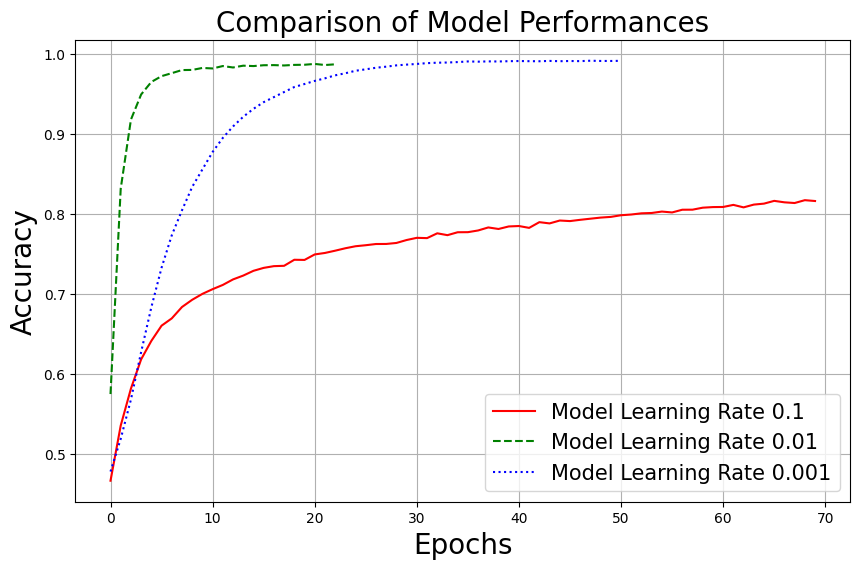

In [78]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
# epochs = range(len(loaded_history_json_2['accuracy']))
plt.plot(range(len(loaded_history_json_8['accuracy'])), loaded_history_json_8['accuracy'], 'r-', label='Model Learning Rate 0.1', linestyle='-')
plt.plot(range(len(loaded_history_json_9['accuracy'])), loaded_history_json_9['accuracy'], 'g-', label='Model Learning Rate 0.01', linestyle='--')
plt.plot(range(len(loaded_history_json_10['accuracy'])), loaded_history_json_10['accuracy'], 'b-', label='Model Learning Rate 0.001', linestyle=':')
plt.title('Comparison of Model Performances', fontsize=20)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.legend(fontsize=15)
plt.grid(True)
plt.show()

In [ ]:
y

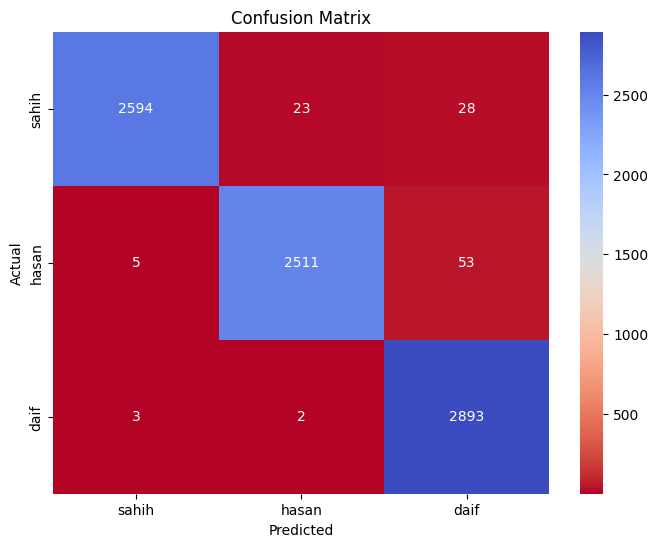

In [ ]:
import seaborn as sns

cm = confusion_matrix(jawaban10, prediksi10)

# Menampilkan confusion matrix menggunakan seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm_r', xticklabels=['sahih', 'hasan', 'daif'], yticklabels=['sahih', 'hasan', 'daif'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

def accuracy_per_class(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    class_accuracy = cm.diagonal() / cm.sum(axis=1)
    return class_accuracy, cm

class_accuracy, cm = accuracy_per_class(jawaban10, prediksi10)
for i, acc in enumerate(class_accuracy):
    print(f"Accuracy for class {i}: {acc}")

Accuracy for class 0: 0.9807183364839319
Accuracy for class 1: 0.9774231218372907
Accuracy for class 2: 0.9982746721877157
